In [1]:
from lib.header_notebook import *
import lib.OTCommon as OTCommon
import lib.SinkhornNP as Sinkhorn
import lib.LinHK as LinHK
import lib.LinW2 as LinW2
import lib.Tools as Tools

%matplotlib inline

# Compute optimal transport between reference and an individual sample
* compute logarithmic map
* some simple examples with exponential map
* do both for W2 and for HK

## Import and setup

In [2]:
# import two samples and the linear mean
datMu=OTCommon.importMeasure("data/two_ellipses_rad0d25/mean.mat",totalMass=1.,keepZero=False)
datNu=OTCommon.importMeasure("data/two_ellipses_rad0d25/sample_000.mat",totalMass=1.,keepZero=False)
res=datMu[3]

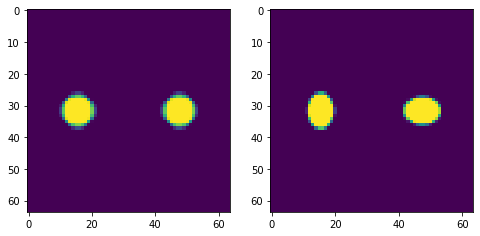

In [3]:
# simple visualization
fig=plt.figure(figsize=(8,4))
for i,dat in enumerate([datMu,datNu]):
    fig.add_subplot(1,2,i+1)
    plt.imshow(dat[0])
plt.show()

In [4]:
mu=datMu[1]
posMu=datMu[2].astype(np.double)

nu=datNu[1]
posNu=datNu[2].astype(np.double)

## Wasserstein-2

In [5]:
params={}
params["setup_HKMode"]=False
params["solver_errorGoal"]=1.E-4
params["aux_verbose"]=False
params["solver_epsStart"]=1E3
params["solver_epsTarget"]=0.1

In [6]:
# solve W transport
value,pi=Sinkhorn.SolveW2(mu,posMu,nu,posNu,
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False
        )
# extract approximate Monge map (which is logarithmic map, up to subtracting initial locations)
T=LinW2.extractMongeData(pi,posNu)

In [7]:
# compare transport cost of piA with the approximate one implied by monge map
print("transport cost coupling:\t",value)

valueMonge=np.einsum((T-posMu)**2,[0,1],mu,[0],[])
print("transport map:\t\t\t",valueMonge)
# the difference between the two values of on the order 1, which corresponds to the discretization scale

transport cost coupling:	 12.751767431484883
transport map:			 11.295105073204466


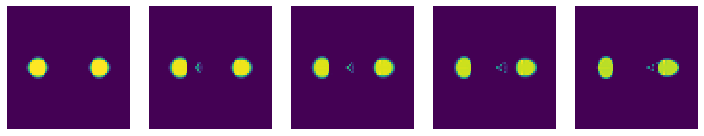

In [8]:
# visualize re-construction of input measure via exponential map
# this will include some numerical artifacts due to:
# discretization and pixels that are split between the two ellipses
tList=np.linspace(0,1,num=5)
fig=plt.figure(figsize=(10,2))
for i,t in enumerate(tList):
    img=Tools.rasterizePointCloud(mu,(1-t)*posMu+t*T,res)
    fig.add_subplot(1,len(tList),i+1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Hellinger--Kantorovich

In [9]:
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=5
params["solver_errorGoal"]=1.E-4
params["aux_verbose"]=False
params["solver_epsStart"]=1E3
params["solver_epsTarget"]=0.1

In [10]:
# solve HK transport
value,pi=Sinkhorn.SolveHK(mu,posMu,nu,posNu,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False
        )

In [11]:
# from optimal coupling compute tangent vector data
u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(pi,mu,nu,posNu)
v0,alpha0=LinHK.HKLog(posMu,u0,x1,u1,params["setup_HKScale"])

In [12]:
# compare transport cost of piA with the approximate one implied by monge map
print("transport cost coupling:\t",value)

valueMonge=LinHK.HKInnerProduct(mu,v0,alpha0,v0,alpha0,HKScale=params["setup_HKScale"])
print("transport map:\t\t\t",valueMonge)
# the difference between the two values of on the order 1, which corresponds to the discretization scale
# now this looks more significant, since the two measures are now much closer to each other

transport cost coupling:	 0.4735332795002504
transport map:			 0.27911908119141404


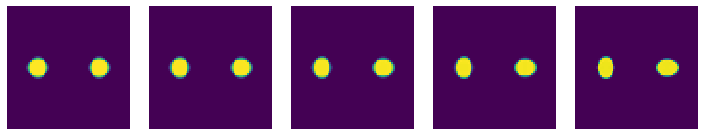

In [13]:
# visualize re-construction of input measure via exponential map
# this will include some numerical artifacts due to discretization
tList=np.linspace(0,1,num=5)
fig=plt.figure(figsize=(10,2))
for i,t in enumerate(tList):
    # shoot averaged tangent vector back to a measure
    expMu,expT=LinHK.HKExp(mu,posMu,t*v0,t*alpha0,HKScale=params["setup_HKScale"])

    img=Tools.rasterizePointCloud(expMu,expT,res)
    fig.add_subplot(1,len(tList),i+1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()